# V01
Stronger Jayes-cummings coupling than V00 and larger readout resonators

In [2]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from scipy.optimize import fsolve
from modeling.utils.qubits import get_Ic_from_Lj, jaynes_cummings_g
from qucat import Network,L,J,C
from modeling.qubits.clockmon.libraries.clockmon_library import clockmon_coupling_libraries, clockmon_library, clockmon_cqr_to_ground
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_library, digit_tee_ck_to_ground, get_ck
from modeling.utils.constants import planck_h, e_charge, phi0
from scqubits import Transmon

In [3]:
smooth_capacitor_lib = digit_tee_library(deembed = [300, 200])
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])
clockmon_lib = clockmon_library(deembed = 200) 
cqr_to_ground = clockmon_cqr_to_ground(deembed = 200)

# Target Parameters

In [4]:
a = 10e-6 # conductor width
b = 6e-6 # gap width
ep_r = 11.45 # substrate relative permittivity

nb_qubits = 6 # number of qubits / readout resonators
rr_freq_target = np.array([7.0e9, 7.15e9, 7.6e9, 7.45e9, 7.3e9, 7.70e9]) # target readout resonator frequencies
qubit_freq_target = np.array([4.5e9, 4.75e9, 5.1e9, 4.95e9, 4.8e9, 5.2e9]) # target qubit frequencies
c_sigma = 90.47e-15 # target qubit shunt capacitance
kappa_target = 5e6 # target resonator linewidth
chi = 1.5e6 # target dispersive shift

Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real
l_r = Z0*pi/(4*pi*rr_freq_target)
c_r = 1/((2*pi*rr_freq_target)**2*l_r)

In [5]:
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real # characteristic impedance of the CPW
l_r = Z0*pi/(4*pi*rr_freq_target) # Effective resonator L
c_r = 1/((2*pi*rr_freq_target)**2*l_r) # Effective resonator C

# Design optimization

In [6]:
def minimize_func(x, c_r = None, l_r = None, target_qubit_frequency = None):
    """Function to minimize the error in chi and qubit frequency by varying
    the coupling capacitor and Josephson inductance."""
    cir = Network([
        C(0, 1, c_sigma), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r), # resonator
        L(0,2,l_r),
        C(1,2, abs(x[0])*1e-15), # coupling capacitor
    ])
    err_chi = abs(cir.kerr(Lj = x[1]*1e-9)[0,1] - 2*chi)
    H = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = x[1]*1e-9)
    ee = H.eigenenergies().real
    ee -= ee[0]
    err_freq = abs(ee[1] - target_qubit_frequency)
    return err_chi, err_freq

In [7]:
cqrs = np.zeros((nb_qubits))
Ljs = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cqr, lj = fsolve(minimize_func, [6, 9], args =(c_r[i], l_r[i], qubit_freq_target[i]))
    cqrs[i] = cqr*1e-15
    Ljs[i] = lj*1e-9

print("Coupling capacitance for each qubit to their readout resonators [F]", cqrs)
print("Josephson inductance for each qubit [H]", Ljs)

Coupling capacitance for each qubit to their readout resonators [F] [9.83778543e-15 8.99066954e-15 8.52085779e-15 8.82066746e-15
 9.13893548e-15 8.33049105e-15]
Josephson inductance for each qubit [H] [1.13955990e-08 1.03568905e-08 9.07645920e-09 9.58473562e-09
 1.01370437e-08 8.75978723e-09]


In [8]:
Ic = get_Ic_from_Lj(Ljs)
EC = e_charge**2/(c_sigma)/2/planck_h
Ej = Ic*phi0/2/pi/planck_h
anharmonicities = np.zeros(nb_qubits)
for i in range(nb_qubits):
    transmon = Transmon(EJ = Ej[i], EC=EC, ng = 0, ncut = 31)
    anharmonicities[i] = transmon.anharmonicity()

Energy dispersion is  5.351254291534423e-07 GHz


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$n_g$', ylabel='energy [GHz]'>)

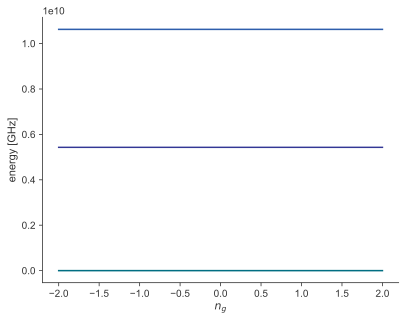

In [9]:
ng_list = np.linspace(-2, 2, 101)
e01_list = []
for ng in ng_list:
    e01_list.append(Transmon(EJ=Ej[0], EC=EC, ng=ng, ncut=31).E01())
e01_min = min(e01_list)
e01_max = max(e01_list)
delta_e01 = (e01_max - e01_min)/1e9
print("Energy dispersion is ", delta_e01, "GHz")
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=3, subtract_ground=True)

In [10]:
# Printout of the mode analysis for each qubit+resonator system
resonator_mode = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cir = Network([
        C(0,1,c_sigma), # transmon
        J(0,1, Ljs[i]),
        C(0,2,c_r[i]), # resonator
        L(0,2,l_r[i]),
        C(1,2, cqrs[i]), # coupling capacitor
        ])
    cir.f_k_A_chi(pretty_print=True)
    H  = cir.hamiltonian(modes = [0, 1],
                taylor = 6, excitations = [10, 10])
    ee = H.eigenenergies().real
    ee -= ee[0]
    resonator_mode[i] = ee[2]

         mode |       freq.  |       diss.  |       anha.  |
            0 |      4.7 GHz |          0Hz |      191 MHz |
            1 |      6.9 GHz |          0Hz |     11.8 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      191 MHz |              |
            1 |        3 MHz |     11.8 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.95 GHz |          0Hz |      192 MHz |
            1 |     7.06 GHz |          0Hz |     11.7 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      192 MHz |              |
            1 |        3 MHz |     11.7 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |      5.3 GHz |          0Hz |      193 MHz |
            1 |      7.5 GHz |          0Hz |     11.7 kHz |

Kerr coefficients (diagonal = Kerr, off-diag

In [11]:
print("Loaded resonator frequencies", resonator_mode)
resonator_mode_shift = rr_freq_target - resonator_mode

Loaded resonator frequencies [6.90170994e+09 7.05556886e+09 7.49828810e+09 7.34914019e+09
 7.19999479e+09 7.59772158e+09]


In [12]:
# Coupling strength and Lamb shift calculation (approximate)
gs = jaynes_cummings_g(Ej, EC, cqrs, c_r, rr_freq_target, lambda_half = False)
delta = (rr_freq_target - transmon.E01()) * 2*np.pi

lamb_shift = 2*gs**2 / delta
print("Coupling strengths g/2pi [Hz]: ", gs/2/pi)
print("Lamb shifts [Hz]: ", lamb_shift/2/pi)

Coupling strengths g/2pi [Hz]:  [2.35328910e+08 2.35998261e+08 2.62477650e+08 2.55685078e+08
 2.48895902e+08 2.67007785e+08]
Lamb shifts [Hz]:  [70565058.07571584 64776646.07083035 63508759.65136755 64740186.82436487
 66269733.0449096  62824237.86403286]


In [13]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0, lambda_half = False)/ 2/ pi
    return abs(k - kappa_target)
cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15
print("Coupling capacitance to feedline for each resonator [F]: ", cks)

Coupling capacitance to feedline for each resonator [F]:  [1.49617051e-14 1.44933602e-14 1.32253679e-14 1.36267955e-14
 1.40489497e-14 1.29685691e-14]


In [14]:
adjusted_resonator_frequencies = rr_freq_target + resonator_mode_shift
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_lengths = v_ph / adjusted_resonator_frequencies / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l))
c_r_loaded -= cqrs
c_r_loaded -= cks
resonator_waveguide_lengths = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
resonator_waveguide_lengths

array([0.008081  , 0.00793086, 0.00746539, 0.00761033, 0.00776101,
       0.0073718 ])

In [15]:
coupler_width_given_c_qr, c_sigma_given_coupler_width = clockmon_coupling_libraries()
ck_given_coupling = get_ck()
for i in range(nb_qubits):
    coupler_width = coupler_width_given_c_qr(cqrs[i])
    finger_control = ck_given_coupling(cks[i])
    print(f"Coupler width for qubit {i}: {coupler_width:.5} um")
    print(f"Finger control for qubit {i}: {finger_control:.5}")
    print(f"Resonator length for qubit {i}: {resonator_waveguide_lengths[i]*1e6:.5} um")

Coupler width for qubit 0: 358.63 um
Finger control for qubit 0: 2.5785
Resonator length for qubit 0: 8081.0 um
Coupler width for qubit 1: 320.65 um
Finger control for qubit 1: 2.5515
Resonator length for qubit 1: 7930.9 um
Coupler width for qubit 2: 300.11 um
Finger control for qubit 2: 2.4767
Resonator length for qubit 2: 7465.4 um
Coupler width for qubit 3: 313.2 um
Finger control for qubit 3: 2.5007
Resonator length for qubit 3: 7610.3 um
Coupler width for qubit 4: 327.21 um
Finger control for qubit 4: 2.5257
Resonator length for qubit 4: 7761.0 um
Coupler width for qubit 5: 291.86 um
Finger control for qubit 5: 2.4611
Resonator length for qubit 5: 7371.8 um


# Quasi-lumped simulation

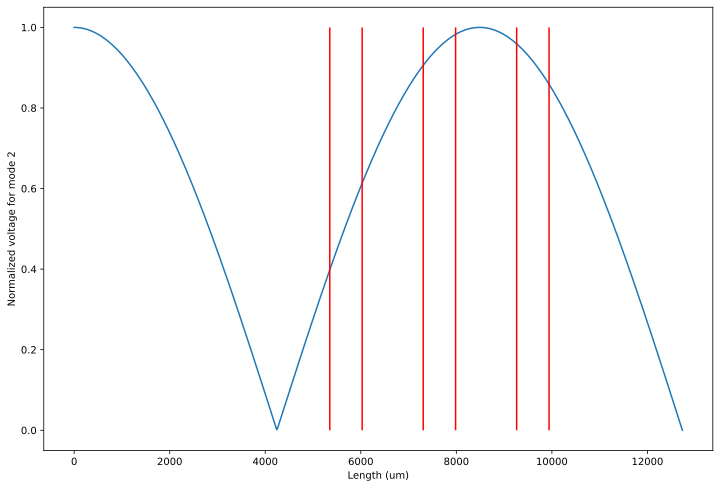

In [16]:
fl_traits = pd.read_csv("single_doublepads_01.csv").values[0][1:]
tee_size = pd.read_csv("single_doublepads_01.csv").values[1][1:]
res_length = pd.read_csv("single_doublepads_01.csv").values[2][1:]

tee_size = tee_size[pd.isna(tee_size) == 0]
res_length =res_length[pd.isna(res_length) == 0]

transmission_line_tee_points = [
    float(fl_traits[0]), # From input launcher to feedline capacitor
    fl_traits[1] + (a + 2*b)/2, # From feedline capacitor to tee0
    fl_traits[2] + (a + 2*b), # From tee0 to tee1
    fl_traits[3] + (a + 2*b), # From tee1 to tee2
    fl_traits[4] + (a + 2*b), # From tee2 to tee3
    fl_traits[5] + (a + 2*b), # From tee3, to tee4 
    fl_traits[6] + (a + 2*b), # From tee4, to tee5
    fl_traits[7] + (a + 2*b), # From tee5, to tee6 (from tee6 we split into output launcher and feedline resonator tail)
    fl_traits[8] + (a + 2*b)/2, # From tee6 to output launcher
    fl_traits[9] + 30, # from tee6 to ground (feedline resonator tail endpoint)
]

feedline_res_length = fl_traits[1] + (a + 2*b)/2 + \
    fl_traits[2] + (a + 2*b) + \
    fl_traits[3] + (a + 2*b) + \
    fl_traits[4] + (a + 2*b) + \
    fl_traits[5] + (a + 2*b) + \
    fl_traits[6] + (a + 2*b) + \
    fl_traits[7] + (a + 2*b) + \
    fl_traits[8] + 30 + fl_traits[9] + (a + 2*b)/2
qb_pos_0 = fl_traits[1] + (a + 2*b)/2
qb_pos_1 = qb_pos_0 + fl_traits[2] + (a + 2*b)
qb_pos_2 = qb_pos_1 + fl_traits[3] + (a + 2*b)
qb_pos_3 = qb_pos_2 + fl_traits[4] + (a + 2*b)
qb_pos_4 = qb_pos_3 + fl_traits[5] + (a + 2*b)
qb_pos_5 = qb_pos_4 + fl_traits[6] + (a + 2*b)

xdata = np.linspace(0, feedline_res_length, 1001)
plt.figure(figsize=(12, 8))
plt.ylabel("Normalized voltage for mode 2")
plt.xlabel("Length (um)")
def resonance_profile(x, total_length, order):
    return abs(np.cos(2*np.pi*x*(order + 1/2)/total_length/2))
plt.plot(xdata, resonance_profile(xdata, feedline_res_length, order = 1))
plt.vlines([qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3, qb_pos_4, qb_pos_5], ymin = 0, ymax = 1, colors="r")
corrections_to_ck = resonance_profile(np.array([qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3, qb_pos_4, qb_pos_5]), feedline_res_length, order = 1)

In [17]:
# resonator_capacitance = c_r_loaded - cks -  cqrs
# resonator_mode
l_r_mode = Z0*pi/(4*pi*resonator_mode)
c_r_mode = 1/((2*pi*resonator_mode)**2*l_r)- cks -  cqrs
cfl = 5e-14
options = {
    "qubit_c": np.array([c_sigma]*6),
    "qubit_l": Ljs,
    "readout_resonator_c": c_r_mode,
    "readout_resonator_l": l_r_mode,
    "ck": cks,
    "ck_to_ground": ck_to_ground(cks),
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "cfl": cfl,
    "cfl_to_ground": ck_to_ground(cfl),
    "frequency": [2, 8],
    "n_points": 1001,
    "type": "feedline_resonator",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}

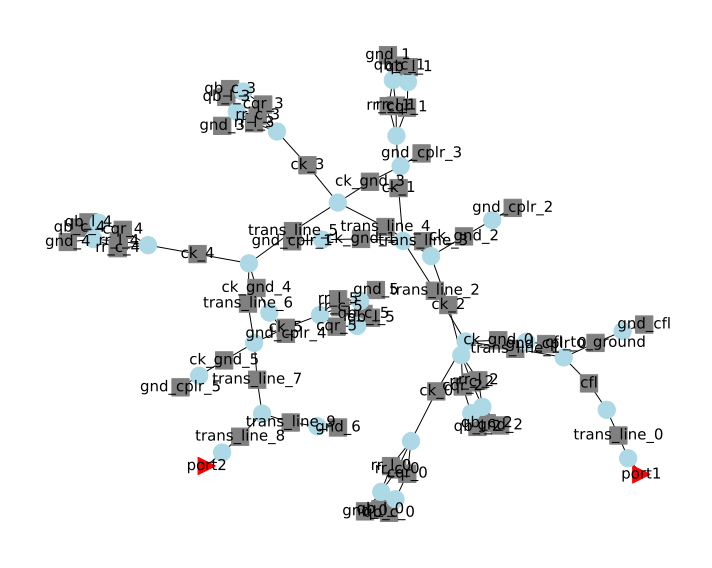

In [18]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)
ntw = cir.network

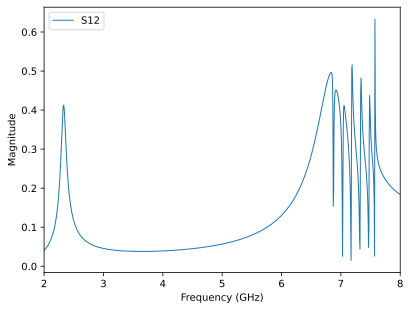

In [19]:
ntw.plot_s_mag(m=0, n=1, lw=1)

In [20]:
# T1 Purcell:
k_purcell = kappa_target* (gs/delta)**2
T1_purcell = 1/(2*np.pi*k_purcell)
print("T1 Purcell-limited [us]", T1_purcell)

T1 Purcell-limited [us] [1.41605877e-06 1.69001596e-06 2.17484102e-06 1.98597139e-06
 1.79603655e-06 2.29987117e-06]


In [21]:
df = pd.DataFrame(['qb0','qb1','qb2', 'qb3', 'qb4', 'qb5'])
df['resonator 01 [GHz]'] = rr_freq_target / 1e9
df['qubit 01 [GHz]'] = qubit_freq_target / 1e9
df['anharmonicity [MHz]'] = anharmonicities / 1e6
df['chi/2pi [MHz]'] = [chi / 1e6]*nb_qubits
df['g/2pi [MHz]'] = gs/2/np.pi / 1e6
df['C_sigma [fF]'] = [c_sigma*1e15]*nb_qubits
df["Lj  [nH]"] = Ljs *1e9
df['Ic [nA]'] = Ic*1e9
df['T1 Purcell [us]'] = T1_purcell * 1e6
df.T

,0,1,2,3,4,5
0,qb0,qb1,qb2,qb3,qb4,qb5
resonator 01 [GHz],7.0,7.15,7.6,7.45,7.3,7.7
qubit 01 [GHz],4.5,4.75,5.1,4.95,4.8,5.2
anharmonicity [MHz],-240.353311,-238.798933,-236.839851,-237.624304,-238.466388,-236.345908
chi/2pi [MHz],1.5,1.5,1.5,1.5,1.5,1.5
g/2pi [MHz],235.32891,235.998261,262.47765,255.685078,248.895902,267.007785
C_sigma [fF],90.47,90.47,90.47,90.47,90.47,90.47
Lj [nH],11.395599,10.356891,9.076459,9.584736,10.137044,8.759787
Ic [nA],28.880095,31.776524,36.259291,34.336469,32.465676,37.570088
T1 Purcell [us],1.416059,1.690016,2.174841,1.985971,1.796037,2.299871
